# Tidying masks post process

In [1]:
from octopuslite import DaskOctopusLiteLoader
import btrack
from tqdm.auto import tqdm
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load segmentation images

#### *Important:* from this point on you will need to be consistent with the use of cropping and alignment. 
Using a previously generated alignment transformation will aid greatly in the tracking notebook, which depends on the object localisation performed in this notebook. Cropping your images will ensure that no border effects from the translational shift are seen. 

In [2]:
# load images
expt = 'ND0018'
pos = 'Pos9'
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=True)

Using cropping: (1200, 1600)


In [3]:
images.channels

[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK_GFP: 98>,
 <Channels.MASK: 99>]

In [11]:
from skimage.io import imshow

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


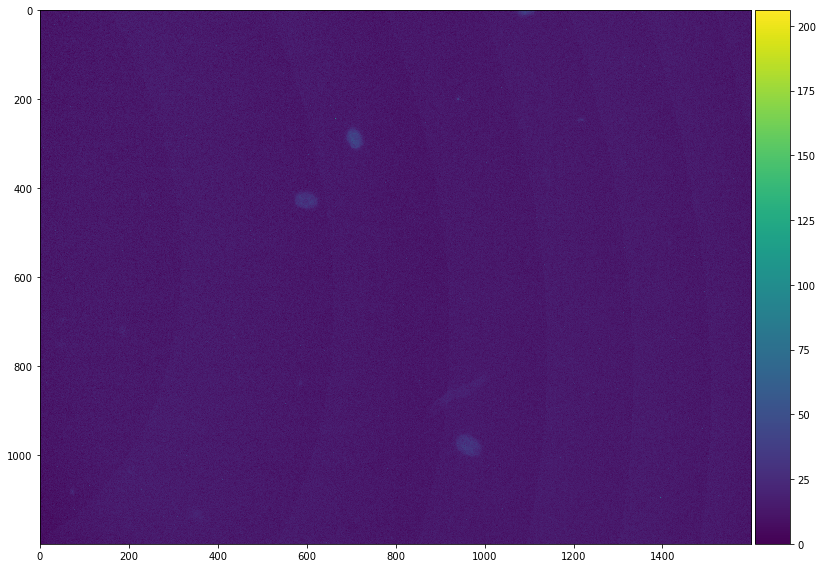

In [17]:
imshow((images['rfp'][0]).astype(np.uint8)*2)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


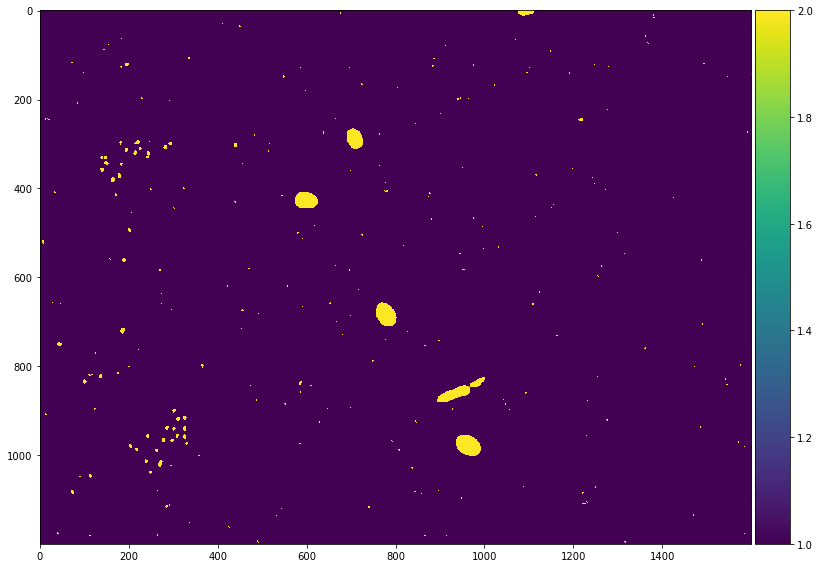

In [14]:
imshow(((images['mask'][0]==2)+1).astype(np.uint8))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


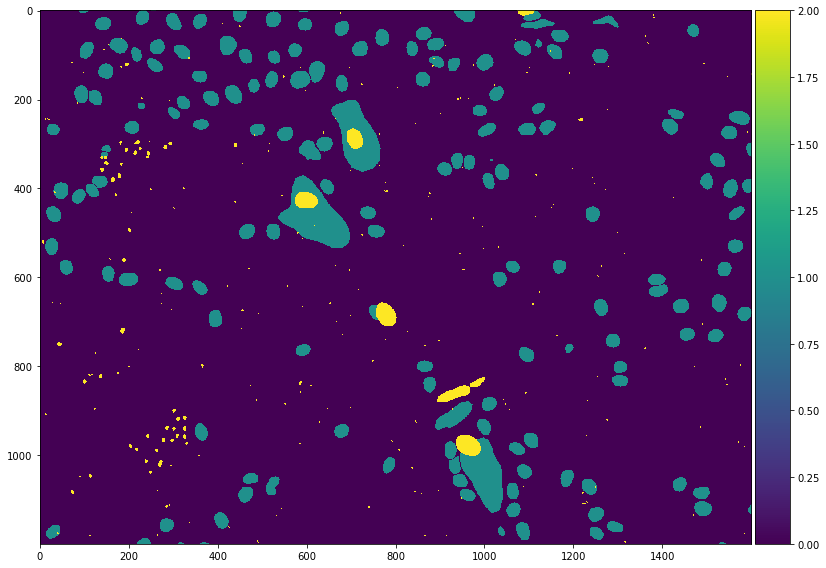

In [369]:
imshow(images['mask'][0])

In [29]:
import scipy.ndimage as ndi

In [43]:
labels, n = ndi.label(images['mask'][0])

In [59]:
# labeling : each region is associated with an int
labels, n = ndi.label(images['mask'][0]==2)
# provide bounding box for each region in the form of tuples of slices
objects = ndi.find_objects(labels)

In [60]:
n

281

In [45]:
objects[0]

(slice(0, 13, None), slice(1073, 1112, None))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


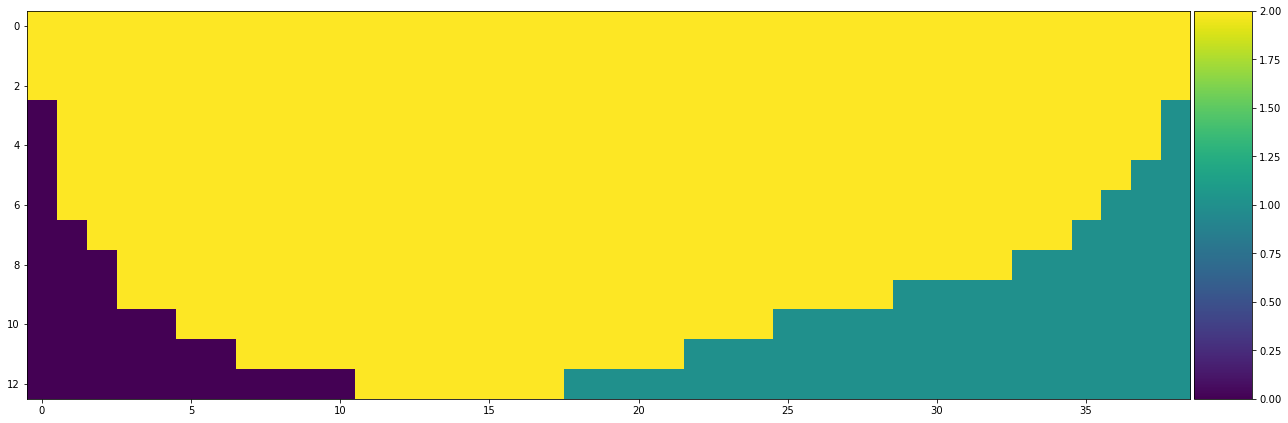

In [49]:
imshow(images['mask'][0][objects[0]])

In [51]:
np.sum(images['mask'][0][objects[0]]).compute()

865.0

In [52]:
images['mask'][0][objects[0]].shape

(13, 39)

In [53]:
13*39

507

In [61]:
# labeling : each region is associated with an int
labels, n = ndi.label(images['mask'][0])
# provide bounding box for each region in the form of tuples of slices
objects = ndi.find_objects(labels)

In [55]:
objects[0]

(slice(0, 7, None), slice(87, 113, None))

In [58]:
n

422

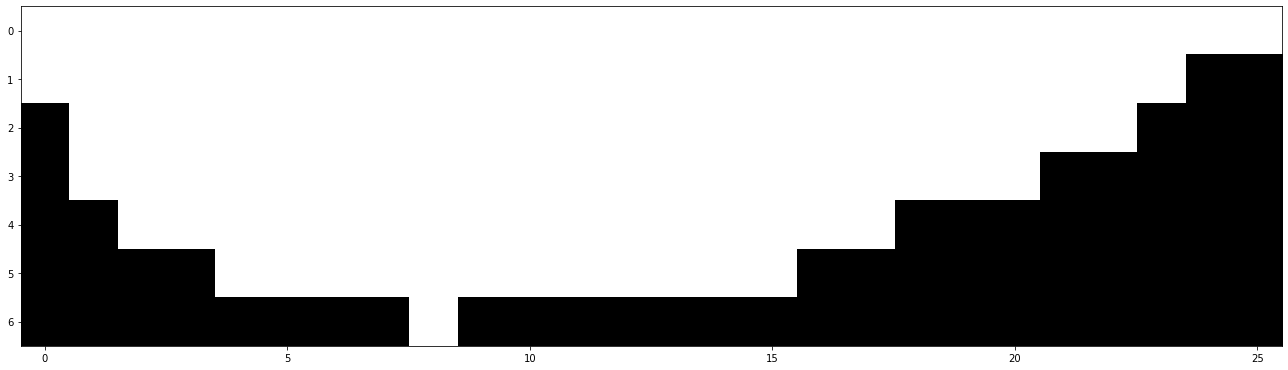

In [65]:
imshow(images['mask'][0][objects[0]])

In [62]:
np.sum(images['mask'][0][objects[0]]).compute()

121.0

In [63]:
images['mask'][0][objects[0]].shape

(7, 26)

In [64]:
7*26

182

In [ ]:
imshow(segment[.astype(int))

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


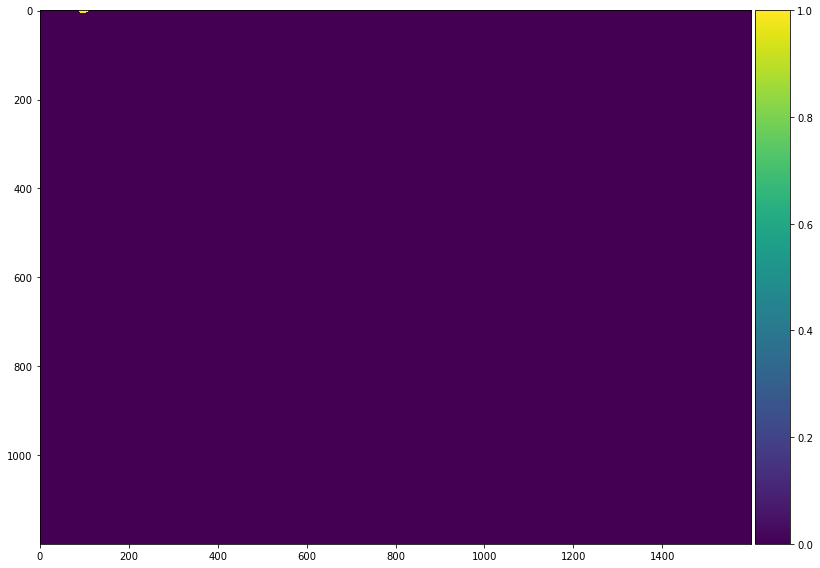

In [28]:
imshow(segment.astype(int))

In [211]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion

In [72]:
regionprops(label(images['mask'][0]==2))[0].area

393

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


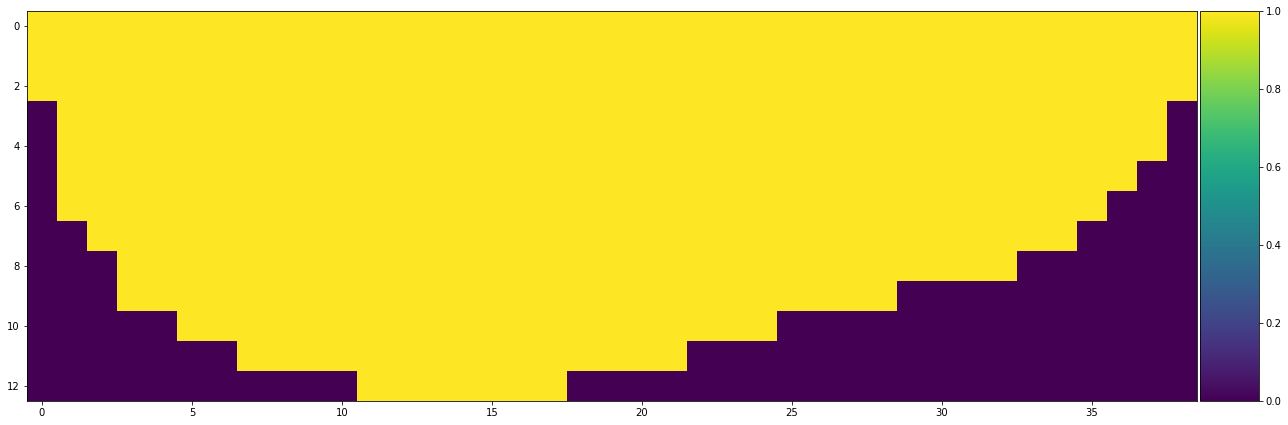

In [77]:
imshow((regionprops(label(images['mask'][0]==2))[0].image).astype(int))

In [79]:
coords = regionprops(label(images['mask'][0]==2))[0].coords

In [82]:
mask = (images['mask'][0] == 2).astype(int)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


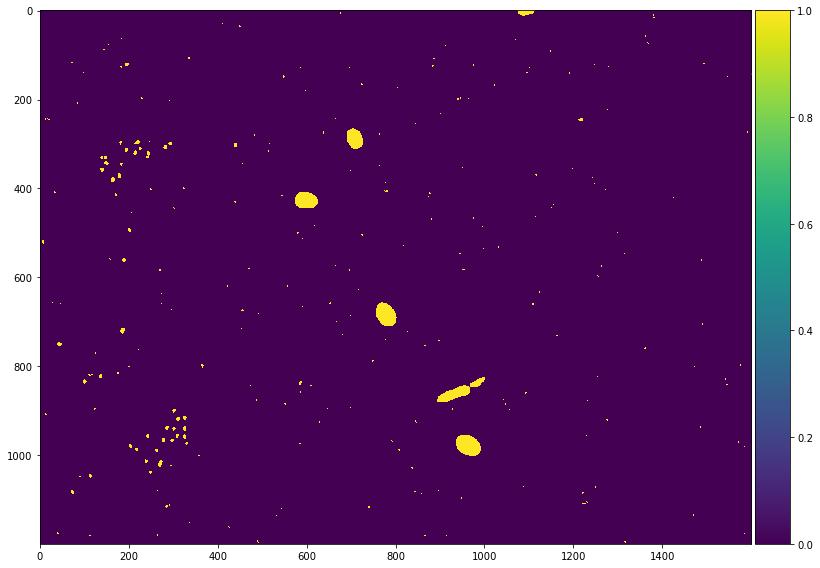

In [83]:
imshow(mask)

In [85]:
for coord in coords:
    mask[coord] = 0

In [97]:
tuple(coord)

(12, 1090)

In [94]:
mask[12,1090].compute()

0

In [98]:
mask[tuple(coord)].compute()

0

In [99]:
mask[coord].compute()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [125]:
type(mask)

numpy.ndarray

In [184]:
mask = (images['mask'][0]).compute().astype(int)

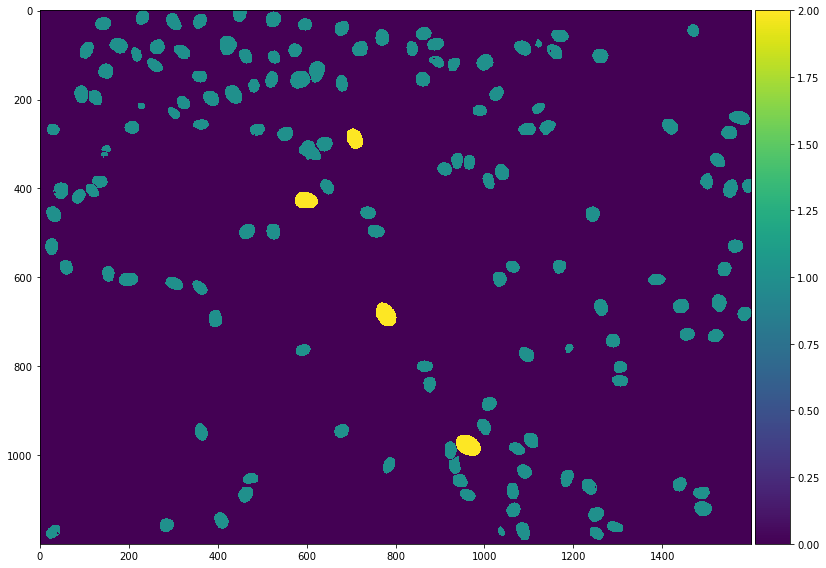

In [192]:
mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.8:
        for coord in region.coords:
            mask[tuple(coord)] = 0
imshow(mask)

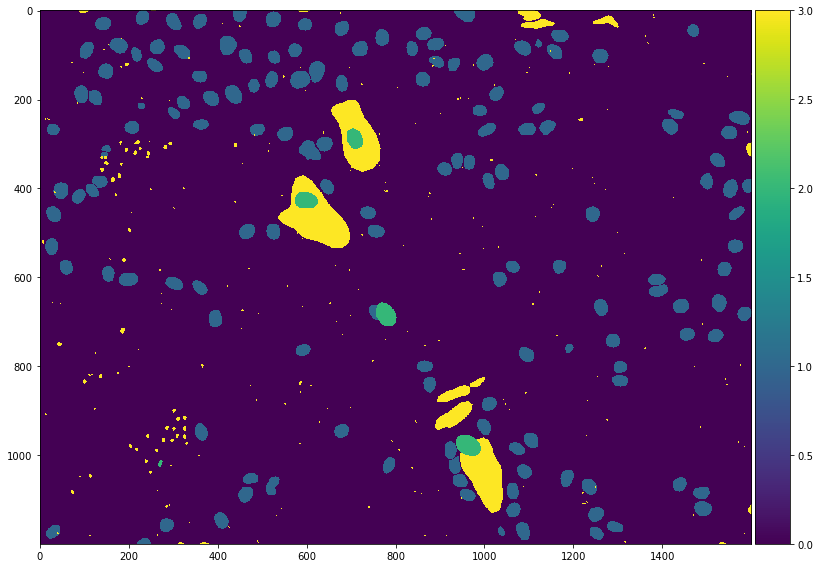

In [197]:
mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.9:
        for coord in region.coords:
            mask[tuple(coord)] = 3
imshow(mask)

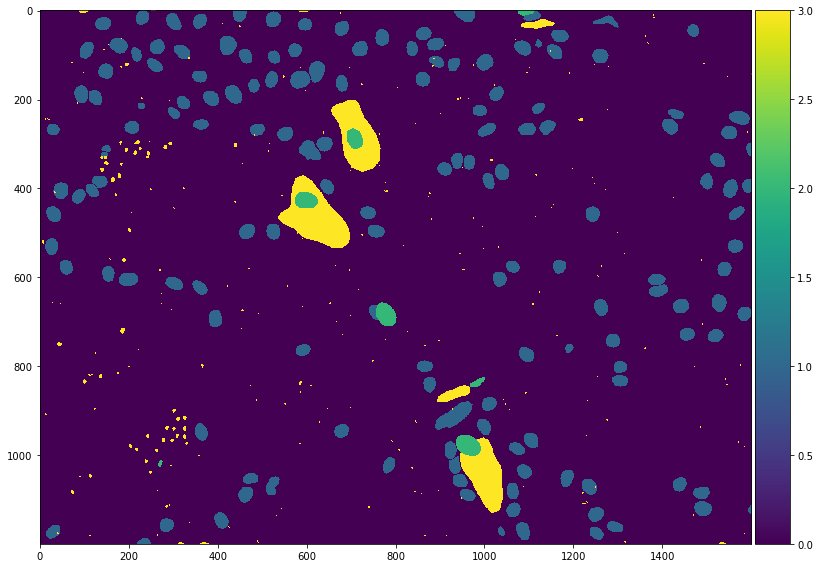

In [198]:
mask = (images['mask'][0]).compute().astype(int)
for region in regionprops(label(mask)):
    if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.95:
        for coord in region.coords:
            mask[tuple(coord)] = 3
imshow(mask)

In [202]:

mask = np.zeros((5,1200,1600))
for i in range(5):
    mask[i] = (images['mask'][i]).compute().astype(int)
    for region in regionprops(label(mask[i])):
        if 4000 <= region.area or region.area <= 100 or region.eccentricity > 0.95:
            for coord in region.coords:
                mask[i][tuple(coord)] = 3

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


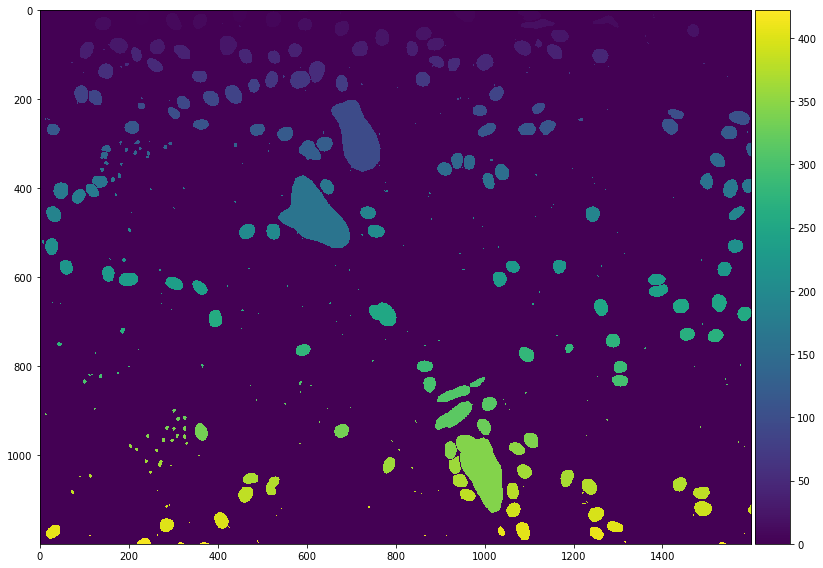

In [209]:
imshow(labels)

In [ ]:
import ndimage

In [240]:
labels = label(images['mask'][0]==1)

# format 2channel mask image and post process
mask = np.zeros(labels.shape)

for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = binary_erosion(labels==i)
    mask[segment] = 1 ## for gfp
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
         for coord in region.coords:
                mask[tuple(coord)] = 3
#     # set background to zero
#     mask[labels == 0] = 0

# # now do the same for the rfp channel
# rfp = imread(fn.replace('channel001', 'channel002'))   
# # predict labels using 2 instances of the model with different params
# labels, details = seg_model.predict_instances(normalize(rfp), prob_thresh=0.2)
labels = label(images['mask'][0]==2)
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = binary_erosion(labels==i)
    mask[segment] = 2 ## for rfp
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
         for coord in region.coords:
                mask[tuple(coord)] = 3

### post processing of images

IndexError: list index out of range

In [241]:
i

4

In [242]:
segment

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


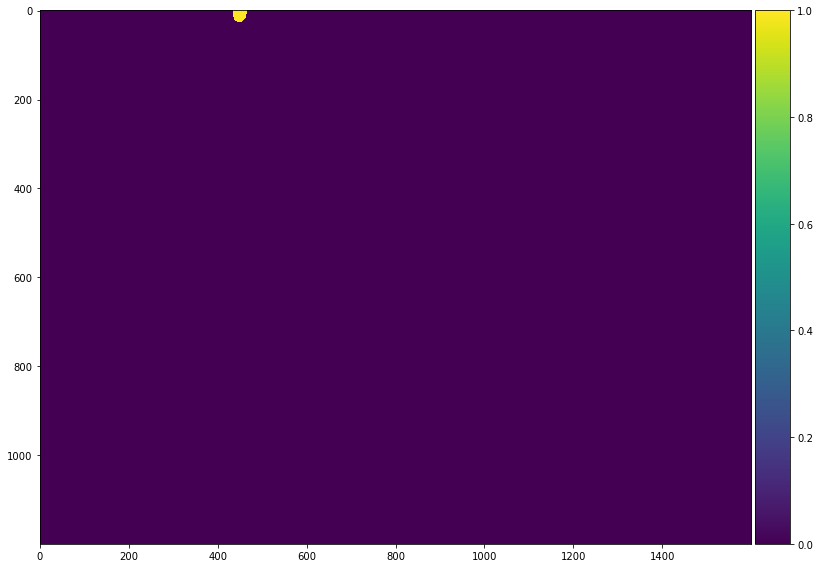

In [246]:
imshow((label(images['mask'][0]==1)==4).astype(int))

In [250]:
import scipy.ndimage as nd

In [253]:
i

4

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


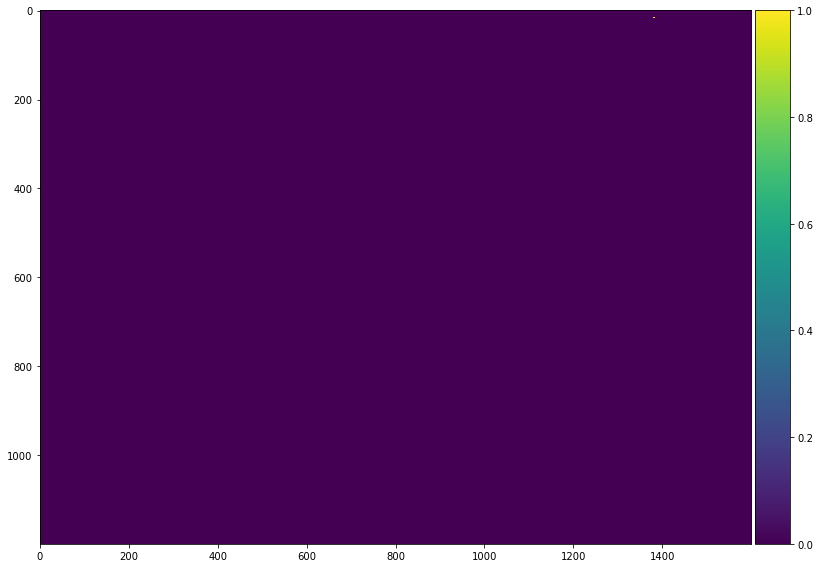

In [258]:
imshow((labels==i).astype(int))

In [256]:
segment = binary_erosion((labels==i).astype(int))

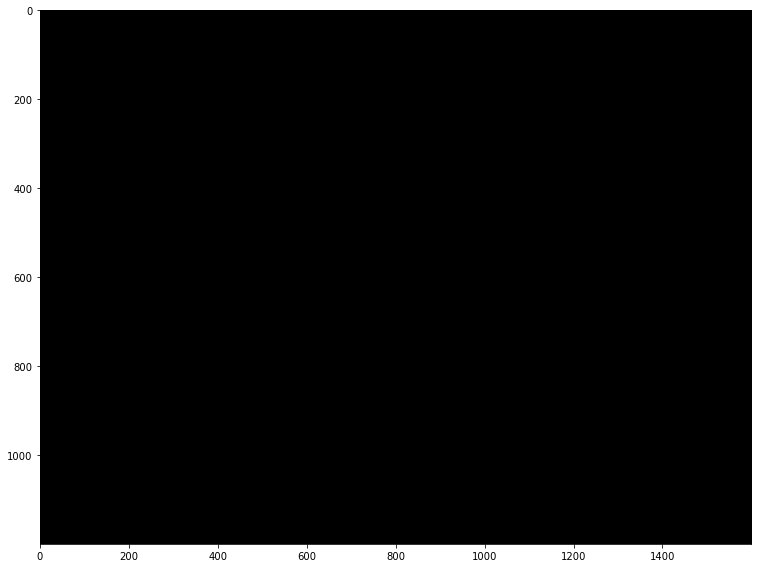

In [257]:
imshow(segment.astype(int))

# fails bc erosion deletes small item

In [259]:
segment = labels == i

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


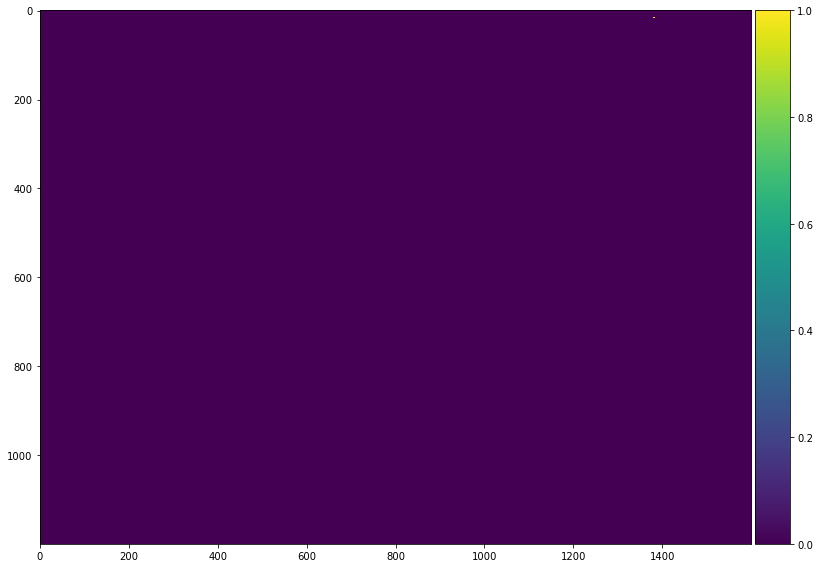

In [261]:
imshow(segment.astype(int))

In [262]:
seg_props = regionprops(label(segment))

In [265]:
seg_props[0].area

6

In [276]:
labels = label(images['mask'][0]==1)

# format 2channel mask image and post process
mask = np.zeros(labels.shape)

for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
        mask[segment] = 3
    else:
        segment = binary_erosion(segment)
        mask[segment] = 1

labels = label(images['mask'][0]==2)
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment))[0]
    if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
        mask[segment] = 3
    else:
        segment = binary_erosion(segment)
        mask[segment] = 2

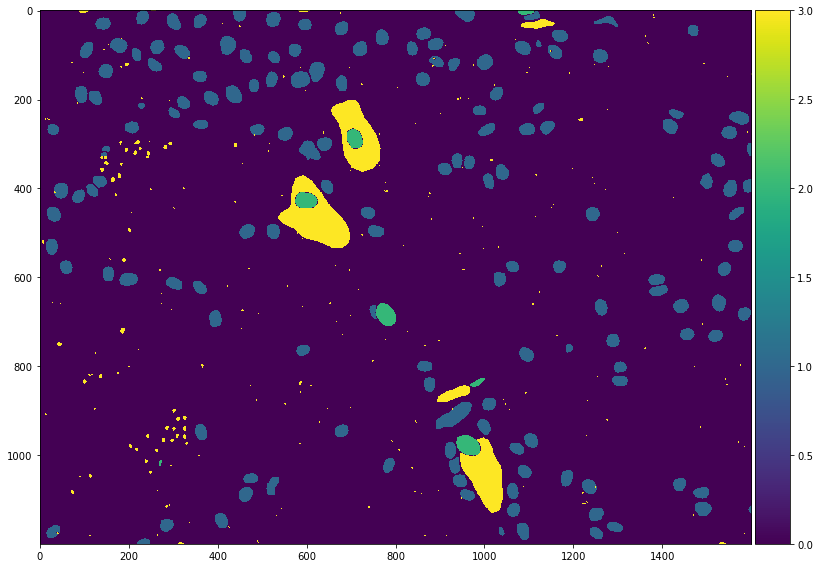

In [325]:
imshow(mask)

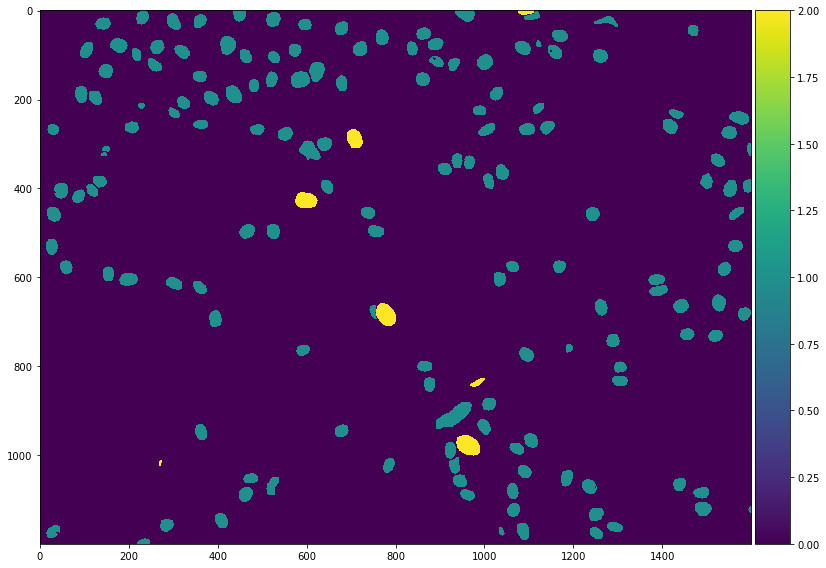

In [291]:
imshow((mask==1).astype(int)+(mask==2).astype(int)*2)

In [326]:
mask_2 = np.zeros((2,1200,1600))

In [327]:
mask_2[0] = mask
mask_2[1] = mask

In [338]:
images['mask'][0]

dask.array<getitem, shape=(1200, 1600), dtype=float32, chunksize=(1200, 1600), chunktype=numpy.ndarray>

In [341]:
from skimage.io import imsave

In [342]:
help(imsave)

Help on function imsave in module skimage.io._io:

imsave(fname, arr, plugin=None, check_contrast=True, **plugin_args)
    Save an image to file.
    
    Parameters
    ----------
    fname : str
        Target filename.
    arr : ndarray of shape (M,N) or (M,N,3) or (M,N,4)
        Image data.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    check_contrast : bool, optional
        Check for low contrast and print warning (default: True).
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    
    Notes
    -----
    When saving a JPEG, the compression ratio may be controlled using the
    ``quality`` keyword argument which is an integer with values in [1, 100]
    where 1 is worst quality and smallest file size, 

In [1]:
import glob

In [6]:
files = glob.glob('/home/nathan/data/kraken/ras/ND00**/Pos*/Pos*_images/*channel098*')

In [7]:
len(files)

31423

In [10]:
from skimage.io import imread, imshow
%matplotlib inline

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


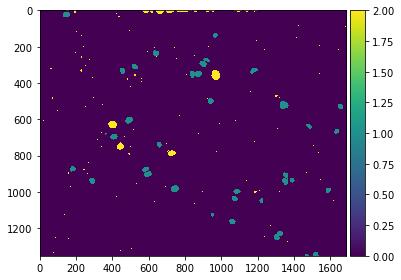

In [11]:
imshow(imread(files[0]))

In [4]:
files = glob.glob('/home/nathan/data/kraken/ras/ND00**/Pos*/Pos*_images/*channel099*')

In [5]:
len(files)

12201

In [5]:
from tqdm.auto import tqdm
import os

In [6]:
files[0]

'/home/nathan/data/kraken/ras/ND0013/Pos8/Pos8_images/img_channel098_position008_time000000158_z000.tif'

In [7]:
from skimage.io import imread, imsave

In [8]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion

In [9]:
from natsort import natsorted
import numpy as np

In [23]:
files = natsorted(files[1*int(len(files)/4):2*int(len(files)/4)])

In [21]:
1*int(len(files)/4)

7855

In [22]:
2*int(len(files)/4)

15710

In [17]:
len(files)

3927

In [24]:
for fn in tqdm(files, total = len(files)):
    
    if os.path.exists(fn.replace('channel098', 'channel099')):
        continue
    input_mask = imread(fn)
    labels = label(input_mask==1)

    # format 2channel mask image and post process
    mask = np.zeros(labels.shape, dtype = np.uint8)

    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 1

    labels = label(input_mask==2)
    
    ### image post processing 
    for i in range(1, np.amax(labels)):
        #needs erosion step to stop merging of labels
        segment = labels == i
        seg_props = regionprops(label(segment))[0]
        if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            #segment = binary_erosion(segment)
            mask[segment] = 2
            
    imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)



  0%|          | 0/7855 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [348]:
images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=True)

Using cropping: (1200, 1600)


In [370]:
objects += btrack.utils.segmentation_to_objects(
    images['mask_gfp']==1,
    properties = ('area', 'eccentricity'),
    assign_class_ID = True,
)

[INFO][2022/04/05 03:17:55 PM] Localizing objects from segmentation...
[INFO][2022/04/05 03:18:49 PM] Objects are of type: <class 'dict'>
[INFO][2022/04/05 03:18:49 PM] ...Found 67156 objects in 397 frames.


In [371]:
len(objects)

69679

In [366]:
objects = btrack.utils.segmentation_to_objects(
    (images['mask_gfp']==2)*2,
    properties = ('area', 'eccentricity'),
    assign_class_ID = True,
)

[INFO][2022/04/05 03:11:46 PM] Localizing objects from segmentation...
[INFO][2022/04/05 03:12:25 PM] Objects are of type: <class 'dict'>
[INFO][2022/04/05 03:12:25 PM] ...Found 2523 objects in 397 frames.


In [373]:
objects[3000]

,ID,x,y,z,t,dummy,states,label,prob,area,eccentricity,class id
0,477,1447.305296,1117.001558,0.0,2,False,0,5,0.0,642,0.556755,1


#### Can also assign measured values from raw image to each segment using `skimage.measure.regionprops` parameters
But also need to load the raw images to be measured first. Cannot currently save out `intensity_image` parameter to object file.

In [ ]:
detailed_objects = btrack.utils.segmentation_to_objects(
    images['mask'], 
    images['gfp'],
    properties = ('area', 'mean_intensity', 'intensity_image'), 
)

In [ ]:
detailed_objects[0]

Example image showing PCNA-iRFP morphology 

In [ ]:
imshow(detailed_objects[0].properties['intensity_image'])

## 2b. Differentiate the objects based on class ID

In [374]:
objects_gfp = [obj for obj in objects if obj.properties['class id'] == 1]
objects_rfp = [obj for obj in objects if obj.properties['class id'] == 2]

## 3. Classify the objects 

Load model

In [375]:
model = load_model('../models/cellx_classifier_stardist.h5')

Define normalisation functions

In [376]:
def normalize_channels(x):

    for dim in range(x.shape[-1]):
        x[..., dim] = normalize(x[..., dim])
        
    return x

def normalize(x):

    xf = x.astype(np.float32)
    mx = np.mean(xf)
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])

    return (xf - mx) / sd

Define classifier function

In [377]:
def classify_objects(image,  gfp, rfp, objects, obj_type):
    
    # define stages of cell cycle to classify (dependent on model type)
    LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]
    
    # iterate over frames
    for n in tqdm(range(image.shape[0])):
        
        # only select objects if in frame
        _objects = [o for o in objects if o.t == n]
        
        # empty placeholder arrays
        crops = []
        to_update = []
        
        # select h2b channel to aid in classification
        fp = gfp if obj_type == 1 else rfp
        
        # create stack by computing each frame of dask array input
        frame = np.stack(
            [image[n, ...].compute(), fp[n, ...].compute()], 
            axis=-1,) 
        
        # create padded image for network
        vol = InfinitePaddedImage(frame, mode = 'reflect')
        
        # iterate over objects 
        for obj in _objects:
            
            # create coords for image slice
            xs = slice(int(obj.x-40), int(obj.x+40), 1)
            ys = slice(int(obj.y-40), int(obj.y+40), 1)
            
            # crop image
            crop = vol[ys, xs, :]
            crop = resize(crop, (64, 64), preserve_range=True).astype(np.float32)
            
            # normalise image
            if crop.shape == (64 ,64, 2):
                crops.append(normalize_channels(crop))
                to_update.append(obj)
            else:
                print(crop.shape)
                
        if not crops:
            continue
            
        # use classifcation model to predict
        pred = model.predict(np.stack(crops, axis=0))
        
        # check correct number of predictions
        assert pred.shape[0] == len(_objects)
        
        # assign labels to objects
        for idx in range(pred.shape[0]):
            obj = _objects[idx]
            
            # assigning details of prediction
            pred_label = np.argmax(pred[idx, ...])
            pred_softmax = softmax(pred[idx, ...])
            logits = {f"prob_{k}": pred_softmax[ki] for ki, k in enumerate(LABELS)}
            
            # write out
            obj.label = pred_label
            obj.properties = logits

    return objects

#### Load raw images for classifier, a colour channel dependent on `obj_type` needed too (i.e. GFP is `obj_type = 1`, RFP is `obj_type = 2`

In [378]:
bf = images['brightfield']
gfp = images['gfp']
rfp = images['rfp']

#### Classify objects

In [ ]:
objects_gfp = classify_objects(bf, gfp, rfp, objects_gfp, obj_type = 1)


  0%|          | 0/397 [00:00<?, ?it/s]

In [ ]:
objects_rfp = classify_objects(bf, gfp, rfp, objects_rfp, obj_type = 2)

#### Inspect an example object

In [12]:
objects_gfp[0]

,ID,x,y,z,t,dummy,states,label,prob,area,class id,prob_interphase,prob_prometaphase,prob_metaphase,prob_anaphase,prob_apoptosis
0,0,160.435897,4.226496,0.0,0,False,0,0,0.0,234,1,1.0,1.944189e-10,1.602896e-10,2.379132e-11,9.544462e-10


#### Save out classified GFP objects

In [13]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects_type_1.h5', 'w', obj_type='obj_type_1',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_gfp)

[INFO][2022/03/30 01:29:58 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0022/Pos12/objects_type_1.h5...
[INFO][2022/03/30 01:30:03 PM] Writing objects/obj_type_1
[INFO][2022/03/30 01:30:03 PM] Writing labels/obj_type_1
[INFO][2022/03/30 01:30:03 PM] Loading objects/obj_type_1 (386145, 5) (386145 filtered: None)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/area (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/class id (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/prob_interphase (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/prob_prometaphase (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/prob_metaphase (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/prob_anaphase (386145,)
[INFO][2022/03/30 01:30:08 PM] Writing properties/obj_type_1/prob_apoptosis (386145,)
[INFO][2022/03/30 01:30:08 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0022/Pos12

#### Save out classified RFP objects

In [15]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects_type_2.h5', 'w', obj_type='obj_type_2',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_rfp)

[INFO][2022/03/30 02:38:14 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0022/Pos12/objects_type_2.h5...
[INFO][2022/03/30 02:38:15 PM] Writing objects/obj_type_2
[INFO][2022/03/30 02:38:15 PM] Writing labels/obj_type_2
[INFO][2022/03/30 02:38:15 PM] Loading objects/obj_type_2 (38765, 5) (38765 filtered: None)
[INFO][2022/03/30 02:38:15 PM] Writing properties/obj_type_2/area (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/class id (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/prob_interphase (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/prob_prometaphase (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/prob_metaphase (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/prob_anaphase (38765,)
[INFO][2022/03/30 02:38:16 PM] Writing properties/obj_type_2/prob_apoptosis (38765,)
[INFO][2022/03/30 02:38:16 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0022/Pos12/objects_

# Saving out as one file

In [ ]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects.h5', 'w', obj_type='obj_type_1',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_gfp)
    
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/objects.h5', 'a', obj_type='obj_type_2',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_rfp)

# 4. Batch process
Iterate over many experiments and positions (need to ensure you define normalisation and classification functions above first)

In [12]:
import time, re

In [26]:
time.sleep(14400)

In [ ]:
%%timeit
root_dir = '/home/nathan/data/kraken/ras'
expt_list = sorted([expt for expt in os.listdir(root_dir) 
                    if 'ND' in expt and os.path.isdir(os.path.join(root_dir, expt))
                    and not '21' in expt 
                    and not '20' in expt], 
                    key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
pos_list = 'all'
overwrite = True

for expt in tqdm(expt_list):
    
    # Find all positions in that experiment, if pos_list is all then it finds all positions
    if pos_list == 'all':
        pos_list = sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
                    if 'Pos' in pos 
                    and os.path.isdir(f'{root_dir}/{expt}/{pos}')], 
                    key = lambda x: [int(y) for y in re.findall(r'\d+', x)])  

    ### Iterate over all positions in that experiment
    for pos in tqdm(pos_list):

        ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
        if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'):
            print(glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'), f'file found, skipping {expt}/{pos}')
            continue

        print(f'Starting {expt}/{pos}')
        # load segmentation images and apply necessary transforms and crops
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
        transform_path = f'{root_dir}/{expt}/{pos}/mask_reversed_clipped_transform_tensor.npy' #gfp_transform_tensor.npy'
        images = DaskOctopusLiteLoader(image_path, 
                           transforms=transform_path,
                           crop=(1200,1600), 
                           remove_background=False)
        
        # ID the objects in each segmentation image and assign option properties to them
        objects = btrack.utils.segmentation_to_objects(
                                                        images['mask'], 
                                                        properties = ('area',),
                                                        assign_class_ID = True
        )

        # differentiate the objects based on class ID
        objects_gfp = [obj for obj in objects if obj.properties['class id'] == 1]
        objects_rfp = [obj for obj in objects if obj.properties['class id'] == 2]

        # load classifcation model and define labels
        model = load_model('../models/cellx_classifier_stardist.h5')
        LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]
        
        # load images for classifcation
        bf = images['brightfield']
        gfp = images['gfp']
        rfp = images['rfp']

        # classify objects
        print("Classifying objects")
        objects_gfp = classify_objects(bf, gfp, rfp, objects_gfp, obj_type = 1)
        objects_rfp = classify_objects(bf, gfp, rfp, objects_rfp, obj_type = 2)

        # save out classified objects as segmentation h5 file
        with btrack.dataio.HDF5FileHandler(
            f'{root_dir}/{expt}/{pos}/objects_type_1.h5', 'w', obj_type='obj_type_1',
        ) as hdf:
            #hdf.write_segmentation(masks['mask'])
            hdf.write_objects(objects_gfp)
        with btrack.dataio.HDF5FileHandler(
            f'{root_dir}/{expt}/{pos}/objects_type_2.h5', 'w', obj_type='obj_type_2',
        ) as hdf:
            #hdf.write_segmentation(masks['mask'])
            hdf.write_objects(objects_rfp)     

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Starting ND0013/Pos0
Using cropping: (1200, 1600)


[INFO][2022/03/23 07:02:56 PM] Localizing objects from segmentation...


In [33]:
transform_path

'/home/nathan/data/kraken/ras/ND0013/Pos3/mask_reversed_transform_tensor_clipped.npy'

In [31]:
np.load(transform_path)

array([[[ 1.00000000e+00,  0.00000000e+00, -6.22149428e+01],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00, -5.46285883e+01],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00, -5.72211371e+01],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       ...,

       [[ 1.00000000e+00,  0.00000000e+00, -5.03624896e-03],
        [ 0.00000000e+00,  1.00000000e+00, -7.44898619e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00,  2.17864873e+00],
        [ 0.00000000e+00,  1.00000000e+00,  9.02855882e-02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 

In [34]:
images = DaskOctopusLiteLoader(image_path, 
                           transforms=transform_path,
                           crop=(1200,1600), 
                           remove_background=False)

Using cropping: (1200, 1600)


# Parallel batch process

In [7]:
def classify(pos):
    ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
    if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'):
        print(glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'), f'file found, skipping {expt}/{pos}')
        return

    print(f'Starting {expt}/{pos}')
    # load segmentation images and apply necessary transforms and crops
    image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    transform_path = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy'
    images = DaskOctopusLiteLoader(image_path, 
                       transforms=transform_path,
                       crop=(1200,1600), 
                       remove_background=False)

    # ID the objects in each segmentation image and assign option properties to them
    objects = btrack.utils.segmentation_to_objects(
        images['mask'], images['mask'],
        properties = ('area', 'max_intensity', ),
    )

    # differentiate the objects based on class ID
    objects_gfp = [obj for obj in objects if obj.properties['max_intensity'] == 1]
    objects_rfp = [obj for obj in objects if obj.properties['max_intensity'] == 2]

    # load classifcation model and define labels
    model = load_model('../models/cellx_classifier_stardist.h5')
    LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]

    # load images for classifcation
    bf = images['brightfield']
    gfp = images['gfp']
    rfp = images['rfp']

    # classify objects
    print("Classifying objects")
    objects_gfp = classify_objects(bf, objects_gfp, obj_type = 1)
    objects_rfp = classify_objects(bf, objects_rfp, obj_type = 2)

    # save out classified objects as segmentation h5 file
    with btrack.dataio.HDF5FileHandler(
        f'{root_dir}/{expt}/{pos}/objects_type_1.h5', 'w', obj_type='obj_type_1',
    ) as hdf:
        #hdf.write_segmentation(masks['mask'])
        hdf.write_objects(objects_gfp)
    with btrack.dataio.HDF5FileHandler(
        f'{root_dir}/{expt}/{pos}/objects_type_2.h5', 'w', obj_type='obj_type_2',
    ) as hdf:
        #hdf.write_segmentation(masks['mask'])
        hdf.write_objects(objects_rfp)     

    return

In [8]:
from multiprocessing import Pool
cpus = os.cpu_count()
cpus

12

In [11]:
pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
                    if 'Pos' in pos 
                    and os.path.isdir(f'{root_dir}/{expt}/{pos}')]
pos_list

['Pos5',
 'Pos11',
 'Pos3',
 'Pos1',
 'Pos8',
 'Pos10',
 'Pos0',
 'Pos2',
 'Pos6',
 'Pos7',
 'Pos9',
 'Pos4']

In [13]:
for expt in expt_list:
    if __name__ == '__main__':
        with Pool(cpus) as p:
            p.map(classify, pos_list)

Starting ND0010/Pos3Starting ND0010/Pos4Starting ND0010/Pos11Starting ND0010/Pos5Starting ND0010/Pos7Starting ND0010/Pos1Starting ND0010/Pos10Starting ND0010/Pos0Starting ND0010/Pos8
Starting ND0010/Pos2
Starting ND0010/Pos9

Starting ND0010/Pos6


Using cropping: (1200, 1600)Using cropping: (1200, 1600)

Using cropping: (1200, 1600)Using cropping: (1200, 1600)Using cropping: (1200, 1600)Using cropping: (1200, 1600)
Using cropping: (1200, 1600)

Using cropping: (1200, 1600)




Using cropping: (1200, 1600)
Using cropping: (1200, 1600)

Using cropping: (1200, 1600)

Using cropping: (1200, 1600)



[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO][2022/02/07 05:18:20 PM] Found intensity_image data
[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO][2022/02/07 05:18:20 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO][2022/02/07 05:18:20 PM] Found intensity_image data
[INFO][2022/02/07 05:18:20 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO][2022/02/07 05:18:20 PM] Found intensity_image data
[INFO][2022/02/07 05:18:20 PM] Found intensity_image data
[INFO][2022/02/07 05:18:20 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO][2022/02/07 05:18:20 PM] Calculating weighted centroids using intensity_image
[INFO][2022/02/07 05:18:20 PM] Localizing objects from segmentation...
[INFO]

KeyboardInterrupt: 